[![Open Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1lGjOO-EZtiWEmyQSRfC6hJjQEBTfqpFh?usp=sharing)

## Data loading and inspection


In [ ]:
import pandas as pd

# Attempting to read the file with a different encoding (ISO-8859-1)
try:
    retail_data = pd.read_csv(file_path, encoding='ISO-8859-1')
    # Display the first few rows of the dataset
    preview = retail_data.head()
except Exception as e:
    preview = str(e)

preview



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## Data analysis and cleaning

In [ ]:


# Checking for missing values
missing_values = retail_data.isnull().sum()

# Exploring the data types of each column
data_types = retail_data.dtypes

# Summarizing the descriptive statistics to identify anomalies or inconsistencies
descriptive_stats = retail_data.describe()

missing_values, data_types, descriptive_stats



(InvoiceNo           0
 StockCode           0
 Description      1454
 Quantity            0
 InvoiceDate         0
 UnitPrice           0
 CustomerID     135080
 Country             0
 dtype: int64,
 InvoiceNo       object
 StockCode       object
 Description     object
 Quantity         int64
 InvoiceDate     object
 UnitPrice      float64
 CustomerID     float64
 Country         object
 dtype: object,
             Quantity      UnitPrice     CustomerID
 count  541909.000000  541909.000000  406829.000000
 mean        9.552250       4.611114   15287.690570
 std       218.081158      96.759853    1713.600303
 min    -80995.000000  -11062.060000   12346.000000
 25%         1.000000       1.250000   13953.000000
 50%         3.000000       2.080000   15152.000000
 75%        10.000000       4.130000   16791.000000
 max     80995.000000   38970.000000   18287.000000)

## Data cleaning and preprocessing

In [ ]:
from datetime import datetime

# 1. Handling missing values
# Dropping rows where 'CustomerID' is missing
cleaned_data = retail_data.dropna(subset=['CustomerID'])

# Considering the nature of 'Description', we can keep the rows with missing descriptions as they are not crucial for clustering
# However, we need to fill these missing values with a placeholder (e.g., "No Description")
cleaned_data['Description'].fillna('No Description', inplace=True)

# 2. Converting 'InvoiceDate' to datetime format
cleaned_data['InvoiceDate'] = pd.to_datetime(cleaned_data['InvoiceDate'], format='%d-%m-%Y %H:%M')

# 3. Investigating and addressing negative values in 'Quantity' and 'UnitPrice'
# Filtering out transactions with negative quantity or unit price as they might indicate returns or errors
cleaned_data = cleaned_data[(cleaned_data['Quantity'] > 0) & (cleaned_data['UnitPrice'] > 0)]

# Displaying the first few rows of the cleaned dataset and the shape of the dataset
cleaned_preview = cleaned_data.head()
cleaned_shape = cleaned_data.shape

cleaned_preview, cleaned_shape

<ipython-input-9-3815da54c1db>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Description'].fillna('No Description', inplace=True)
<ipython-input-9-3815da54c1db>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['InvoiceDate'] = pd.to_datetime(cleaned_data['InvoiceDate'], format='%d-%m-%Y %H:%M')


(  InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  UnitPrice  CustomerID         Country  
 0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
 1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
 3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
 4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  ,
 (397884, 8))

## Feature selection for hierarchical clustering

In [ ]:
# For customer segmentation, we can create features that reflect the purchasing behavior of each customer.
# We will create the following features:
# 1. Total Spend per Customer
# 2. Average Unit Price per Customer
# 3. Total Quantity Purchased per Customer
# 4. Frequency of Purchase (number of unique invoices per customer)

# 1. Total Spend per Customer
cleaned_data['TotalSpend'] = cleaned_data['Quantity'] * cleaned_data['UnitPrice']

# Aggregating data per customer
customer_data = cleaned_data.groupby('CustomerID').agg(
    TotalSpend=('TotalSpend', 'sum'),
    AverageUnitPrice=('UnitPrice', 'mean'),
    TotalQuantity=('Quantity', 'sum'),
    Frequency=('InvoiceNo', 'nunique')
)

# Displaying the first few rows of the customer_data dataframe
customer_data.head()

,TotalSpend,AverageUnitPrice,TotalQuantity,Frequency
CustomerID,,,,
12346.0,77183.60,1.040000,74215,1
12347.0,4310.00,2.644011,2458,7
12348.0,1797.24,5.764839,2341,4
12349.0,1757.55,8.289041,631,1
12350.0,334.40,3.841176,197,1


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data)

# Converting the scaled data back to a DataFrame for better readability
customer_data_scaled_df = pd.DataFrame(customer_data_scaled, columns=customer_data.columns, index=customer_data.index)

# Displaying the first few rows of the standardized customer data
customer_data_scaled_df.head()


,TotalSpend,AverageUnitPrice,TotalQuantity,Frequency
CustomerID,,,,
12346.0,8.358668,-0.100205,14.473038,-0.425097
12347.0,0.250966,-0.053315,0.251058,0.354417
12348.0,-0.028596,0.037918,0.227869,-0.035340
12349.0,-0.033012,0.111708,-0.111047,-0.425097
12350.0,-0.191347,-0.018318,-0.197065,-0.425097


## Applying Hierarchical Clustering

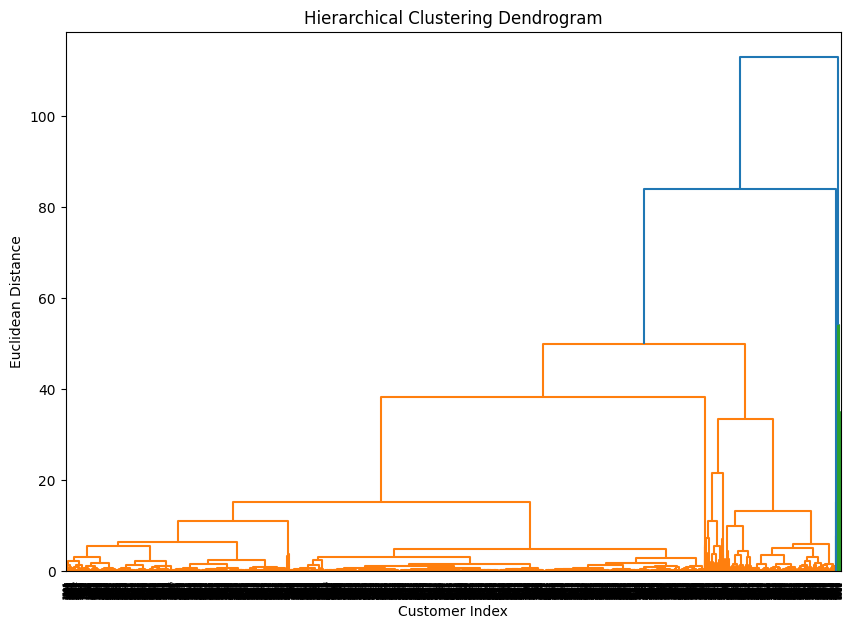

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Using the 'ward' method to minimize the variance of clusters being merged.
linked = linkage(customer_data_scaled_df, method='ward')

# Plotting the dendrogram to help determine the optimal number of clusters
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Euclidean Distance')
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Applying Hierarchical Clustering with a predetermined number of clusters (5 in this case)
n_clusters = 5
hclust = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
clusters = hclust.fit_predict(customer_data_scaled_df)

# Adding the cluster labels to the customer data
customer_data_scaled_df['Cluster'] = clusters

# Displaying the first few rows of the customer data with cluster labels
clustered_data_preview = customer_data_scaled_df.head()
clustered_data_preview



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,TotalSpend,AverageUnitPrice,TotalQuantity,Frequency,Cluster
CustomerID,,,,,
12346.0,8.358668,-0.100205,14.473038,-0.425097,0
12347.0,0.250966,-0.053315,0.251058,0.354417,4
12348.0,-0.028596,0.037918,0.227869,-0.035340,1
12349.0,-0.033012,0.111708,-0.111047,-0.425097,1
12350.0,-0.191347,-0.018318,-0.197065,-0.425097,1


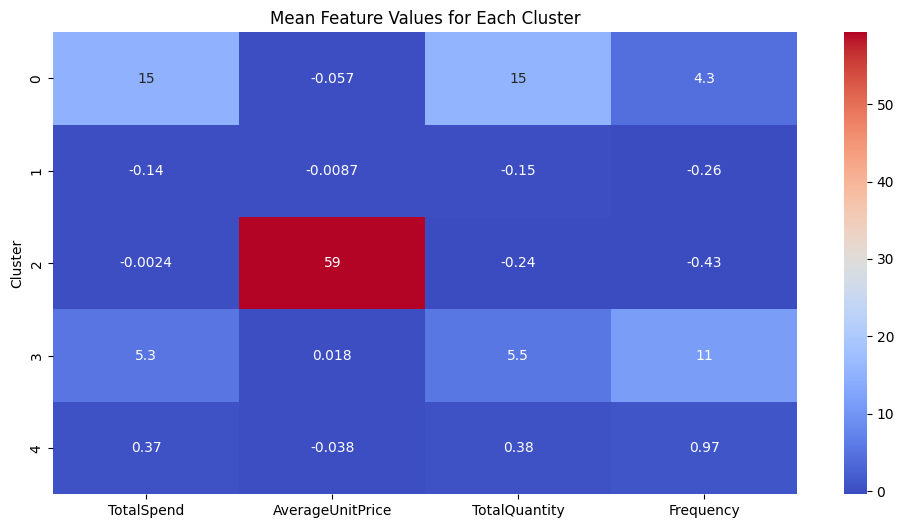

(         TotalSpend  AverageUnitPrice  TotalQuantity  Frequency
 Cluster                                                        
 0         14.908954         -0.057050      15.222527   4.299227
 1         -0.141364         -0.008729      -0.145889  -0.256166
 2         -0.002355         59.303714      -0.235911  -0.425097
 3          5.275748          0.018375       5.468465  11.267603
 4          0.366432         -0.037820       0.380483   0.973306,
 0      11
 1    3580
 2       1
 3      14
 4     732
 Name: Cluster, dtype: int64)

In [ ]:
import seaborn as sns

# Analyzing the clusters

# Calculating the mean of each feature in each cluster
cluster_means = customer_data_scaled_df.groupby('Cluster').mean()

# Plotting the mean of each feature for each cluster
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Mean Feature Values for Each Cluster')
plt.show()

# Count of customers in each cluster
cluster_counts = customer_data_scaled_df['Cluster'].value_counts().sort_index()

cluster_means, cluster_counts



In [ ]:
# Merging the cluster labels with the original data to get the country information
merged_data = pd.merge(cleaned_data, customer_data_scaled_df['Cluster'], on='CustomerID')

# Analyzing customer demographics per cluster based on country
country_cluster_distribution = merged_data.groupby(['Cluster', 'Country']).size().unstack(fill_value=0)

# Displaying the country distribution for each cluster
country_cluster_distribution



Country,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
Cluster,,,,,,,,,,,,,,,,,,,,,
0,714,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4217,0
1,187,398,17,1261,32,151,384,570,25,380,...,57,9,222,1345,178,1225,179,68,161587,244
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21694,0
4,281,0,0,770,0,0,364,44,0,0,...,0,0,0,1139,273,616,0,0,166822,0


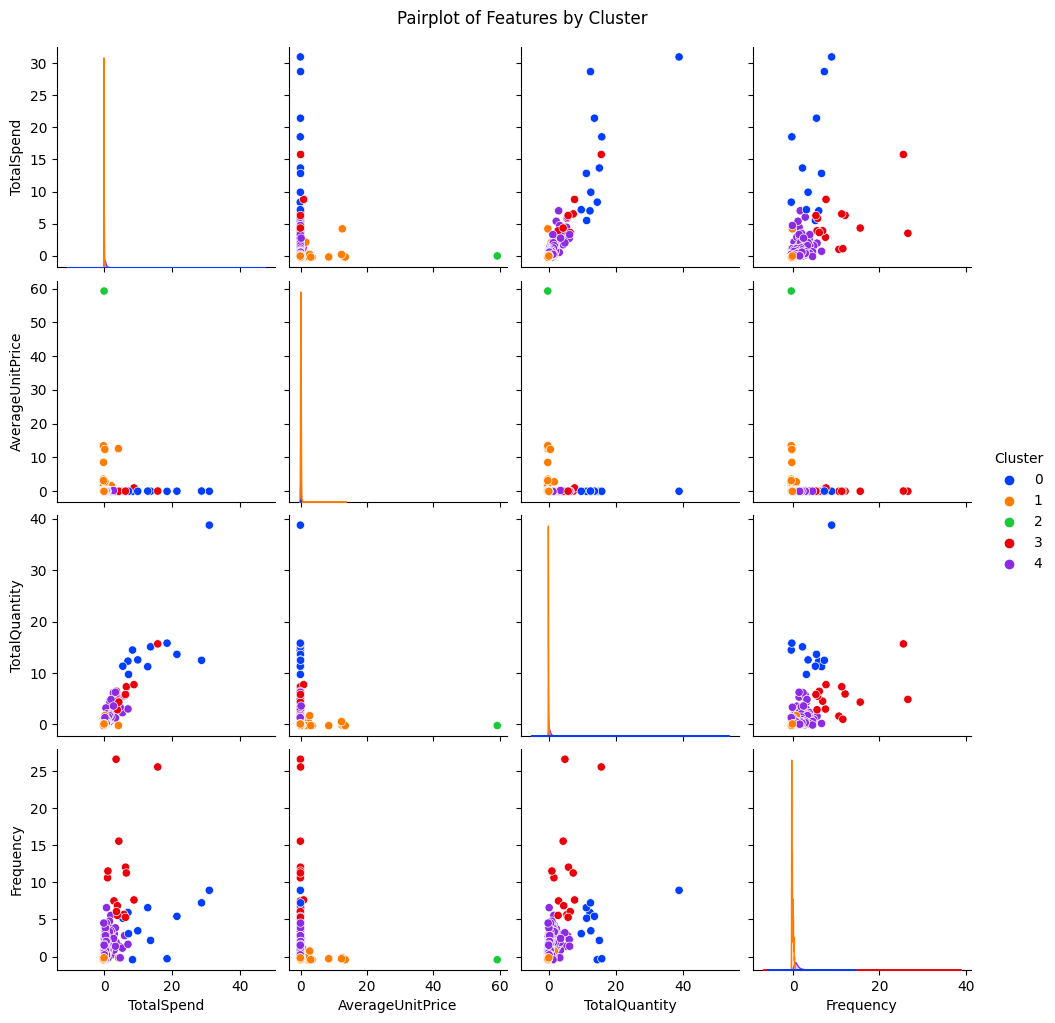

In [ ]:
# Plotting the final clustering results
# Since the dataset is multi-dimensional and can't be visualized directly in 2D or 3D space,
# we will use a pairplot to visualize the relationships between different features for each cluster

sns.pairplot(customer_data_scaled_df, hue='Cluster', palette='bright')
plt.suptitle("Pairplot of Features by Cluster", y=1.02)  # Adjust title position
plt.show()
